# 13.3 Automatic Parallelism

Deep learning frameworks (e.g., MXNet and PyTorch) automatically construct computational graphs at the backend. Using a computational graph, the system is aware of all the dependencies, and can selectively execute multiple non-interdependent tasks in parallel to improve speed. 

Typically, a single operator will use all the computational resources on all CPUs or on a single GPU. For example, the dot operator will use all cores (and threads) on all CPUs, even if there are multiple CPU processors on a single machine. The same applies to a single GPU. Hence parallelization is not quite so useful for single-device computers. With multiple devices things matter more. While parallelization is typically most relevant between multiple GPUs, adding the local CPU will increase performance slightly.

With the convenience of an automatically parallelizing framework we can accomplish the same goal in a few lines of Python code. More broadly, our discussion of automatic parallel compuation focuses on parallel computation using obth CPUs and GPUs, as wella s the parallelization of computation and communication.


In [1]:
import torch
from d2l import torch as d2l

## 13.3.1 Parallel Computation on GPUs

In [3]:
devices = d2l.try_all_gpus()
def run(x):
    return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])

In [4]:
run(x_gpu1)
run(x_gpu2)  # Warm-up all devices
torch.cuda.synchronize(devices[0])
torch.cuda.synchronize(devices[1])
with d2l.Benchmark('GPU1 time'):
    run(x_gpu1)
    torch.cuda.synchronize(devices[0])
with d2l.Benchmark('GPU2 time'):
    run(x_gpu2)
    torch.cuda.synchronize(devices[1])

GPU1 time: 1.6029 sec
GPU2 time: 1.6026 sec


If we remove the synchronize statement between both tasks the system is free to parallelize computation on both devices automatically.

In [5]:
with d2l.Benchmark('GPU1 & GPU2'):
    run(x_gpu1)
    run(x_gpu2)
    torch.cuda.synchronize()

GPU1 & GPU2: 1.6019 sec


## 13.3.2 Parallel Computation and Communication

In many cases we need to move data between different devices, say between the CPU and GPU, or between different GPUs. For instance, this occurs when we want to perform dis- tributed optimization where we need to aggregate the gradients over multiple accelerator cards. Let’s simulate this by computing on the GPU and then copying the results back to the CPU.

In [6]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]
with d2l.Benchmark('Run on GPU1'):
    y = run(x_gpu1)
    torch.cuda.synchronize()
with d2l.Benchmark('Copy to CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

Run on GPU1: 1.6024 sec
Copy to CPU: 2.2067 sec


This is somewhat inefficient. Note that we could already start copying parts of y to the CPU while the remainder of the list is still being computed. This situation occurs, e.g., when we compute the (backprop) gradient on a minibatch.

In PyTorch, several functions such as to() and copy_() admit an explicit non_blocking argument, which lets the caller bypass synchronization when it is unnecessary. Setting non_blocking=True allows us to simulate this scenario.

In [7]:
with d2l.Benchmark('Run on GPU1 and copy to CPU'):
    y = run(x_gpu1)
    y_cpu = copy_to_cpu(y, True)
    torch.cuda.synchronize()

Run on GPU1 and copy to CPU: 2.0726 sec


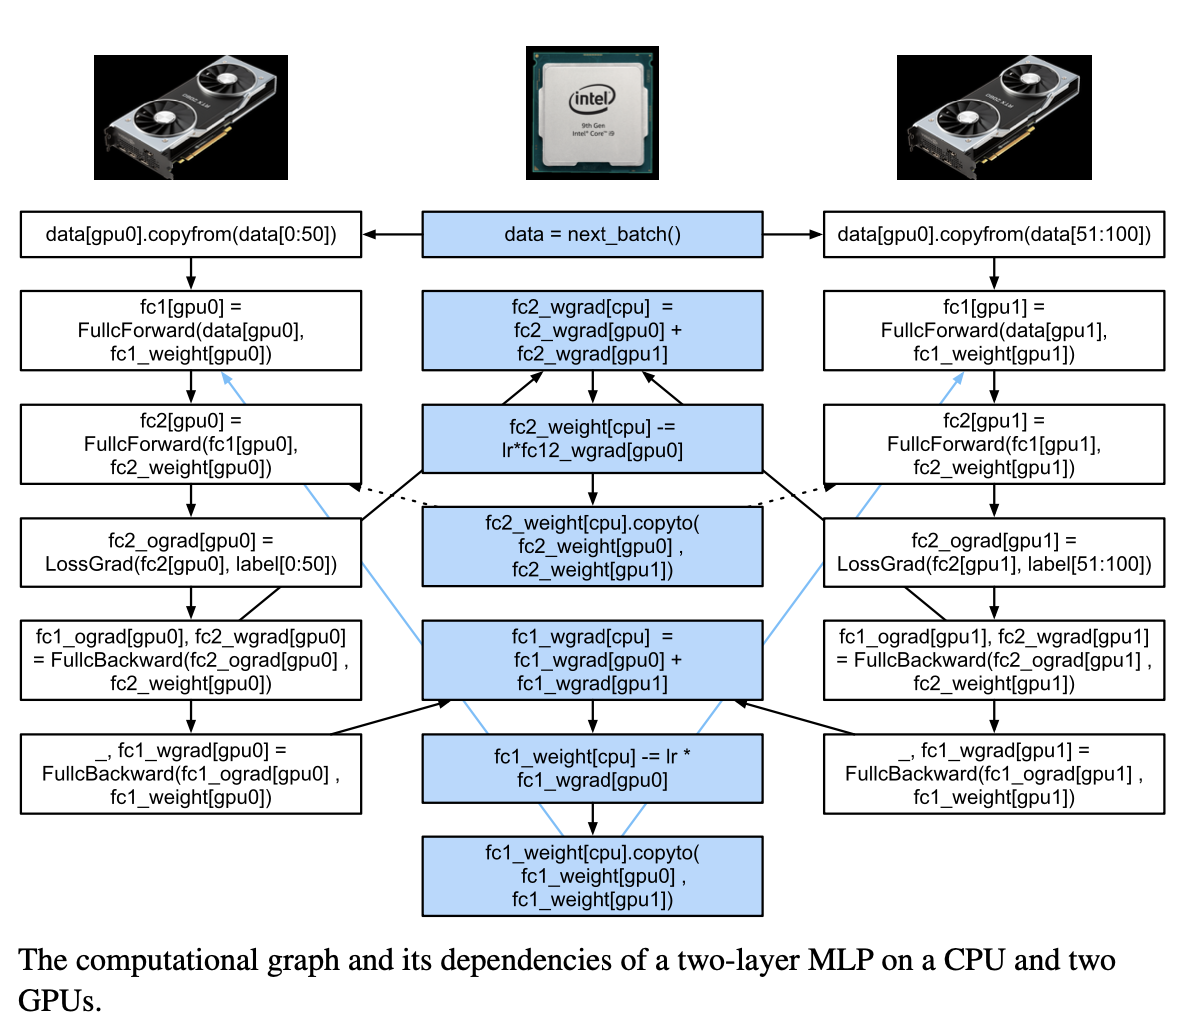